In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-10-27 16:09:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
R'esolution de storage.googleapis.com (storage.googleapis.com)... 172.217.18.80
Connexion `a storage.googleapis.com (storage.googleapis.com)|172.217.18.80|:443... connect'e.
requ^ete HTTP transmise, en attente de la r'eponse... 200 OK
Taille : 70827 (69K) [application/octet-stream]
Sauvegarde en : << /tmp/sunspots.csv >>

/tmp/sunspots.csv   100%[===================>]  69.17K   261KB/s    ds 0.3s    

2019-10-27 16:09:11 (261 KB/s) - << /tmp/sunspots.csv >> sauvegard'e [70827/70827]



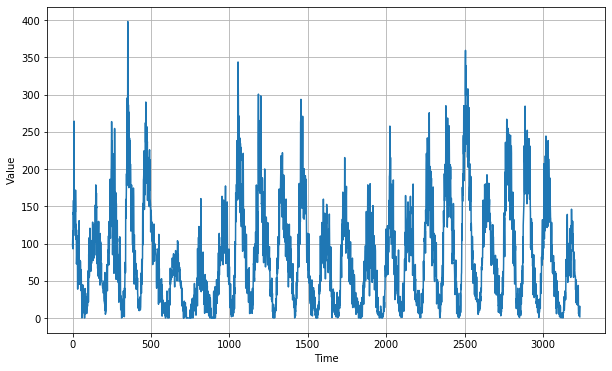

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9))
model.fit(dataset, epochs = 100)

Epoch 1/100
92/92 [==============================] - 4s 44ms/step - loss: 1610.6843
Epoch 2/100
92/92 [==============================] - 2s 24ms/step - loss: 1040.7234
Epoch 3/100
92/92 [==============================] - 2s 23ms/step - loss: 922.1501
Epoch 4/100
92/92 [==============================] - 2s 23ms/step - loss: 852.8240
Epoch 5/100
92/92 [==============================] - 2s 22ms/step - loss: 820.6467
Epoch 6/100
92/92 [==============================] - 2s 24ms/step - loss: 789.0814
Epoch 7/100
92/92 [==============================] - 2s 24ms/step - loss: 781.7677
Epoch 8/100
92/92 [==============================] - 2s 23ms/step - loss: 756.8614
Epoch 9/100
92/92 [==============================] - 2s 24ms/step - loss: 753.0485
Epoch 10/100
92/92 [==============================] - 2s 23ms/step - loss: 740.1251
Epoch 11/100
92/92 [==============================] - 2s 24ms/step - loss: 733.2008
Epoch 12/100
92/92 [==============================] - 2s 27ms/step - loss: 717.3897

92/92 [==============================] - 2s 26ms/step - loss: 585.8444
Epoch 99/100
92/92 [==============================] - 2s 24ms/step - loss: 582.9839
Epoch 100/100
92/92 [==============================] - 2s 24ms/step - loss: 584.8421


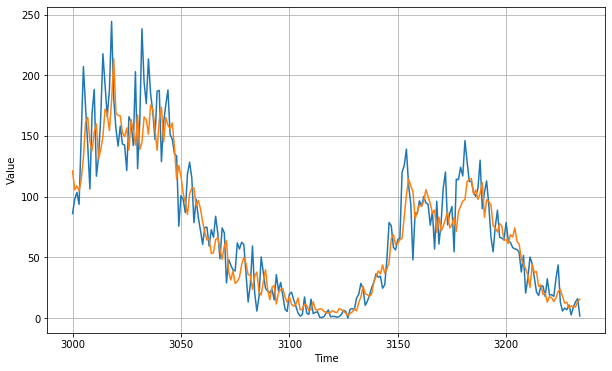

In [8]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.000377